In [6]:
import numpy as np

# generate data

In [3]:
# In real-world scenarios, learning how the data was generated is impractical. Do not rely on this function while doing research.
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [437]:
# example
x, y, mr = generate_data(5, 100)

In [438]:
x[:5], y[:5]

(array([[ 10.39390727, -14.75993306,   0.71581353,   6.54351692,
         -11.05016941],
        [ -4.47680577,  -5.37780586,  21.34536376,   8.63860371,
          10.17295218],
        [-12.00681629,   8.10918986,  -3.29122011,  15.6076735 ,
         -17.69406872],
        [-20.25832859,   1.10414517,  -8.68141728,  -6.82799536,
          -4.38152685],
        [ 16.21069855,   5.50945788,   7.77024774,  12.99833393,
          -7.72010123]]),
 array([[ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.]]))

# write your model class

In [39]:
# Modifying the overall structure is acceptable but not recommended
class LinearSVM:
    def __init__(self, learning_rate=0.0001, lambda_param=0.001, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.losses = []
        self.accuracies = []
    def fit(self, X, y , X_test, y_test):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        # Gradient Descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - (x_i*y_[idx]))
                    self.b -= self.lr * y_[idx]
            loss = self.compute_loss(X, y_)
            self.losses.append(loss)

            # 计算测试准确率
            acc = self.compute_accuracy(X_test, y_test)
            self.accuracies.append(acc)

    def predict(self, X):
        linear_output = np.dot(X, self.w) - self.b
        return np.sign(linear_output)
    def compute_loss(self, X, y):
        distances = 1 - y * (np.dot(X, self.w) - self.b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = (np.sum(distances) / len(X))
        return hinge_loss

    def compute_accuracy(self, X, y):
        y_pred = self.predict(X)
        y_true = y
        #print(y_true.shape, y_pred.shape)
        total=0
        right=0
        for i in range(len(y_true)):
            total+=1
            if y_true[i][0]==y_pred[i]:
                right+=1
        return right/total


In [102]:
class SVM2:
    def __init__(self, X, y, C, tolerance, max_passes):
        self.X = X
        self.y = y
        self.C = C
        self.tol = tolerance
        self.max_passes = max_passes
        self.m, self.n = X.shape
        self.alphas = np.zeros(self.m, dtype=np.float32)
        self.b = 0
        self.w = np.zeros(self.n, dtype=np.float32)
    def f(self, x):
        return np.dot(x, self.w) + self.b
        return ((self.alphas * self.y)*np.dot(self.X, x.T)).sum() + self.b

    def choose_and_update(self, i):
        E_i = self.f(self.X[i]) - self.y[i]
        #print("i=",i,"E_i=",E_i)
        if ((self.y[i] * E_i < -self.tol and self.alphas[i] < self.C) or 
            (self.y[i] * E_i > self.tol and self.alphas[i] > 0)):
            
            j = np.random.randint(0, self.m)
            while j == i:
                j = np.random.randint(0, self.m)
            
            E_j = self.f(self.X[j]) - self.y[j]
            alpha_i_old, alpha_j_old = self.alphas[i], self.alphas[j]

            if self.y[i] != self.y[j]:
                L = max(0, self.alphas[j] - self.alphas[i])
                H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
            else:
                L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                H = min(self.C, self.alphas[i] + self.alphas[j])

            if L == H:
                return 

            eta = 2.0 * np.dot(self.X[i], self.X[j].T) - np.dot(self.X[i], self.X[i].T) - np.dot(self.X[j], self.X[j].T)
            if eta >= 0:
                return 

            self.alphas[j] -= self.y[j] * (E_i - E_j) / eta
            self.alphas[j] = min(H, self.alphas[j])
            self.alphas[j] = max(L, self.alphas[j])

            if abs(self.alphas[j] - alpha_j_old) < 1e-3:
                return 

            self.alphas[i] += self.y[i] * self.y[j] * (alpha_j_old - self.alphas[j])

            b1 = self.b - E_i - self.y[i] * (self.alphas[i] - alpha_i_old) * np.dot(self.X[i], self.X[i].T) - self.y[j] * (self.alphas[j] - alpha_j_old) * np.dot(self.X[i], self.X[j].T)
            b2 = self.b - E_j - self.y[i] * (self.alphas[i] - alpha_i_old) * np.dot(self.X[i], self.X[j].T) - self.y[j] * (self.alphas[j] - alpha_j_old) * np.dot(self.X[j], self.X[j].T)

            if 0 < self.alphas[i] < self.C:
                self.b = b1
            elif 0 < self.alphas[j] < self.C:
                self.b = b2
            else:
                self.b = (b1 + b2) / 2.0
            self.w = 0
            for i in range(self.m):
                self.w += self.alphas[i] * self.y[i] * self.X[i]
            return 
        return 

    def fit(self):
        passes = 0
        for i in range(self.max_passes):
            self.choose_and_update(i%self.m)
            if passes%10==1:
                pass
                #print("passes=",passes)
            passes += 1
            
            

    def predict(self, X):
        y_pred = np.zeros((X.shape[0]))
        for i in range(X.shape[0]):
            if(i%10==1):
                print("i=",i)
            y_pred[i] = np.sign(self.f(X[i]))
        return y_pred




In [105]:
feature_num=20
data_size=10000
train_ratio=0.8
split_id=int(data_size*train_ratio)
X_data, y_data, mislabel = generate_data(feature_num,data_size)
# split data
X_train, y_train = X_data[:split_id], y_data[:split_id]
X_test, y_test = X_data[split_id:], y_data[split_id:]
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)
model2 = SVM2(X_train, y_train, C=1, tolerance=0.001, max_passes=100000)
model2.fit()

passes= 1
passes= 11
passes= 21
passes= 31
passes= 41
passes= 51
passes= 61
passes= 71
passes= 81
passes= 91
passes= 101
passes= 111
passes= 121
passes= 131
passes= 141
passes= 151
passes= 161
passes= 171
passes= 181
passes= 191
passes= 201
passes= 211
passes= 221
passes= 231
passes= 241
passes= 251
passes= 261
passes= 271
passes= 281
passes= 291
passes= 301
passes= 311
passes= 321
passes= 331
passes= 341
passes= 351
passes= 361
passes= 371
passes= 381
passes= 391
passes= 401
passes= 411
passes= 421
passes= 431
passes= 441
passes= 451
passes= 461
passes= 471
passes= 481
passes= 491
passes= 501
passes= 511
passes= 521
passes= 531
passes= 541
passes= 551
passes= 561
passes= 571
passes= 581
passes= 591
passes= 601
passes= 611
passes= 621
passes= 631
passes= 641
passes= 651
passes= 661
passes= 671
passes= 681
passes= 691
passes= 701
passes= 711
passes= 721
passes= 731
passes= 741
passes= 751
passes= 761
passes= 771
passes= 781
passes= 791
passes= 801
passes= 811
passes= 821
passes= 831
pas

In [106]:
y_pred = model2.predict(X_test)
print(y_pred.reshape(-1,1))
print(y_test.reshape(-1,1))
print("Accuracy:", np.mean(y_pred.reshape(-1,1) == y_test.reshape(-1,1)))

i= 1
i= 11
i= 21
i= 31
i= 41
i= 51
i= 61
i= 71
i= 81
i= 91
i= 101
i= 111
i= 121
i= 131
i= 141
i= 151
i= 161
i= 171
i= 181
i= 191
i= 201
i= 211
i= 221
i= 231
i= 241
i= 251
i= 261
i= 271
i= 281
i= 291
i= 301
i= 311
i= 321
i= 331
i= 341
i= 351
i= 361
i= 371
i= 381
i= 391
i= 401
i= 411
i= 421
i= 431
i= 441
i= 451
i= 461
i= 471
i= 481
i= 491
i= 501
i= 511
i= 521
i= 531
i= 541
i= 551
i= 561
i= 571
i= 581
i= 591
i= 601
i= 611
i= 621
i= 631
i= 641
i= 651
i= 661
i= 671
i= 681
i= 691
i= 701
i= 711
i= 721
i= 731
i= 741
i= 751
i= 761
i= 771
i= 781
i= 791
i= 801
i= 811
i= 821
i= 831
i= 841
i= 851
i= 861
i= 871
i= 881
i= 891
i= 901
i= 911
i= 921
i= 931
i= 941
i= 951
i= 961
i= 971
i= 981
i= 991
i= 1001
i= 1011
i= 1021
i= 1031
i= 1041
i= 1051
i= 1061
i= 1071
i= 1081
i= 1091
i= 1101
i= 1111
i= 1121
i= 1131
i= 1141
i= 1151
i= 1161
i= 1171
i= 1181
i= 1191
i= 1201
i= 1211
i= 1221
i= 1231
i= 1241
i= 1251
i= 1261
i= 1271
i= 1281
i= 1291
i= 1301
i= 1311
i= 1321
i= 1331
i= 1341
i= 1351
i= 1361
i= 1371
i= 1381

# construct and train your models

In [36]:
feature_num=20
data_size=10000
train_ratio=0.8
split_id=int(data_size*train_ratio)

In [37]:
X_data, y_data, mislabel = generate_data(feature_num,data_size)
# split data
X_train, y_train = X_data[:split_id], y_data[:split_id]
X_test, y_test = X_data[split_id:], y_data[split_id:]

import matplotlib.pyplot as plt

In [40]:
svm = LinearSVM(learning_rate=0.00001, lambda_param=0.00001, n_iters=30)
svm.fit(X_train, y_train, X_test, y_test)

In [41]:
def accuracy(y_true, y_pred):
    print(y_true.shape, y_pred.shape)
    total=0
    right=0
    for i in range(len(y_true)):
        total+=1
        if y_true[i][0]==y_pred[i]:
            right+=1
    return right/total

In [42]:
print(accuracy(y_test, svm.predict(X_test)))

(2000, 1) (2000,)
0.9555


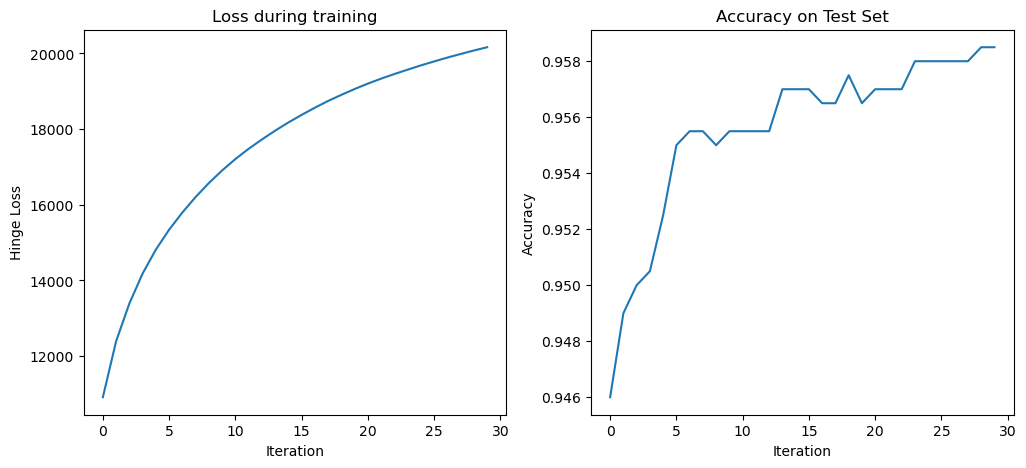

In [446]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(svm.losses)
plt.title("Loss during training")
plt.xlabel("Iteration")
plt.ylabel("Hinge Loss")

plt.subplot(1, 2, 2)
plt.plot(svm.accuracies)
plt.title("Accuracy on Test Set")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

plt.show()

[ 0.10294102 -1.31928782  0.29607082 -0.05806017 -1.10551318 -0.26958987
 -0.00470266 -0.23833761 -0.76693123 -1.06051469] [1.6]


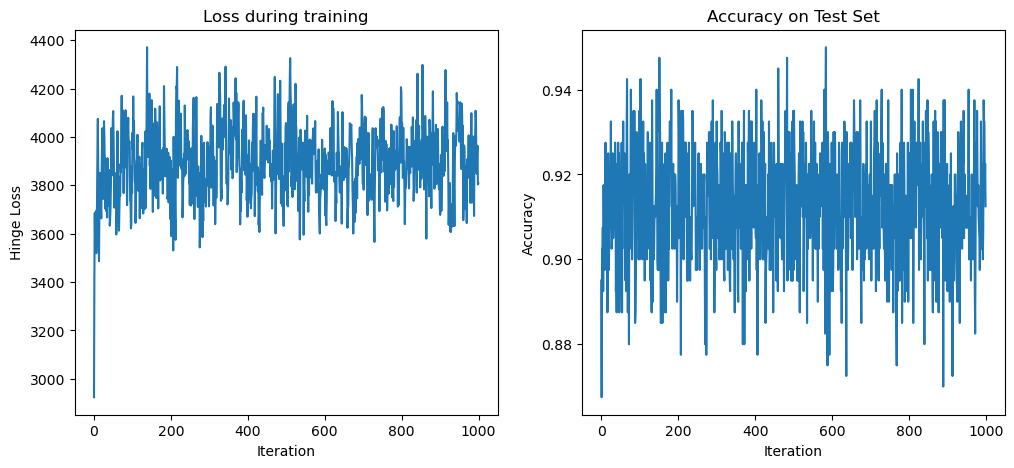

In [447]:
# generate data
feature_num=20
data_size=10000
train_ratio=0.8
split_id=int(data_size*train_ratio)

X_data, y_data, mislabel = generate_data(feature_num,data_size)
# split data
X_train, y_train = X_data[:split_id], y_data[:split_id]
X_test, y_test = X_data[split_id:], y_data[split_id:]
import matplotlib.pyplot as plt

# 初始化和训练模型
svm = LinearSVM(learning_rate=0.01, lambda_param=0.001, n_iters=100)
svm.fit(X_train, y_train, X_train, y_train)
print(svm.w, svm.b)
# 绘制损失和准确率
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(svm.losses)
plt.title("Loss during training")
plt.xlabel("Iteration")
plt.ylabel("Hinge Loss")

plt.subplot(1, 2, 2)
plt.plot(svm.accuracies)
plt.title("Accuracy on Test Set")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

plt.show()


# predict and compare your results

In [448]:
# make prediction
# pred = model1.predict()

# compare with generated label

# compare each method(in terms of accuracy, time consumption, etc.)

# (Optional) compare with sklearn
